***
***
<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;text-align:center;">
    <b><h1>&nbsp Fruit360 - PyTorch - CNN </h1></b>
</div>

***
***

Fruits360 Dataset consists of 90,483 fruit images (Training: 67692 - Test: 22688). All images have white background. Their size is 100x100. There are 131 fruit classes.

I will use Convolutional Neural Networks in PyTorch. PyTorch will give us more control over the network (with extra workload).

Since they have white background with clear fruit images, recognition will be easy with the correct architecture. I know images having no real world backgrounds will make it unsuccessfull in real world images.

At first I have tried Adabound as optimizer, since starting with Adam and shifting to SGD + Momentum generaly shows good results. (Source: [Improving Generalization Performance by Switching from Adam to SGD](https://arxiv.org/abs/1712.07628)). Yet I see Adam is more succesfull in this dataset. So I choose Adam.

Without Learning Rate Scheduler and Early Stopping, it achieves best accuracy approximately in 70th epoch. With some little changes, it now achieves best accuracy in between 20th-30th epoch.

I have deleted most of the data augmentation code, since the model is better without them.

<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp Index</h2></b>
</div>

1. [Import Libraries](#1)
2. [Data Loaders](#2)
3. [Exploration](#3)
4. [Learning Rate Scheduler & EarlyStopping](#4)
5. [CNN Model](#5)
6. [Instantiate Classes](#6)
7. [Training](#7)
8. [Analyse Results](#8)
9. [Summary](#9)

<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "1">1 - Import Libraries </a></h2></b>
</div>

In [21]:
# !pip install adabound
!pip install torchsummary 
import numpy as np
import os, os.path
import math
from torchsummary import summary
from datetime import datetime
# from adabound import AdaBound
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.image as mpimg

<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "2">2 - Data Loaders </a></h2></b>
</div>

In [22]:
num_epochs = 100
batch_size = 512
image_height = 100
image_width = 100
num_channels = 3

# train_dir = "/home/alison/Desktop/Fruit360/fruits-360_dataset/fruits-360/Training"
# test_dir = "/home/alison/Desktop/Fruit360/fruits-360_dataset/fruits-360/Test"

train_dir = "/home/alison/Desktop/ClassificationCutFruit/Training"
test_dir = "/home/alison/Desktop/ClassificationCutFruit/Test"

transforms_data = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       transforms.Resize((image_height, image_width)),
                                       ])

train_dataset = ImageFolder(train_dir, transform=transforms_data)
test_dataset = ImageFolder(test_dir, transform=transforms_data)
num_classes = len(train_dataset.classes)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True)

print('Train Dataset Size: ', len(train_dataset))
print('Test Dataset Size: ', len(test_dataset))

Train Dataset Size:  13971
Test Dataset Size:  688


In [23]:
CUDA = torch.cuda.is_available()
if CUDA:
    print(f"Using GPU")

Using GPU


<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "3">3 - Exploration </a></h2></b>
</div>

**First, we will show some fruits:**

In [24]:
# fig, ax = plt.subplots(1,4,figsize=(12, 9), dpi=120)
# plt.setp(ax, xticks=[], yticks=[])

# ax[0].imshow(mpimg.imread(train_dir+'/Apple Braeburn/0_100.jpg'))
# ax[1].imshow(mpimg.imread(train_dir+'/Banana/0_100.jpg'))
# ax[2].imshow(mpimg.imread(train_dir+'/Avocado ripe/0_100.jpg'))
# ax[3].imshow(mpimg.imread(train_dir+'/Cherry 2/105_100.jpg'))

# plt.show()

**Then, we will look into fruit category counts:**

In the below plots we see that:
* The dataset is balanced, every category has similar counts with some exceptions
* Testing Data has the same counts as Training Data

This is good for training. Otherwise, our model would have difficulty learning small-sized fruit categories.

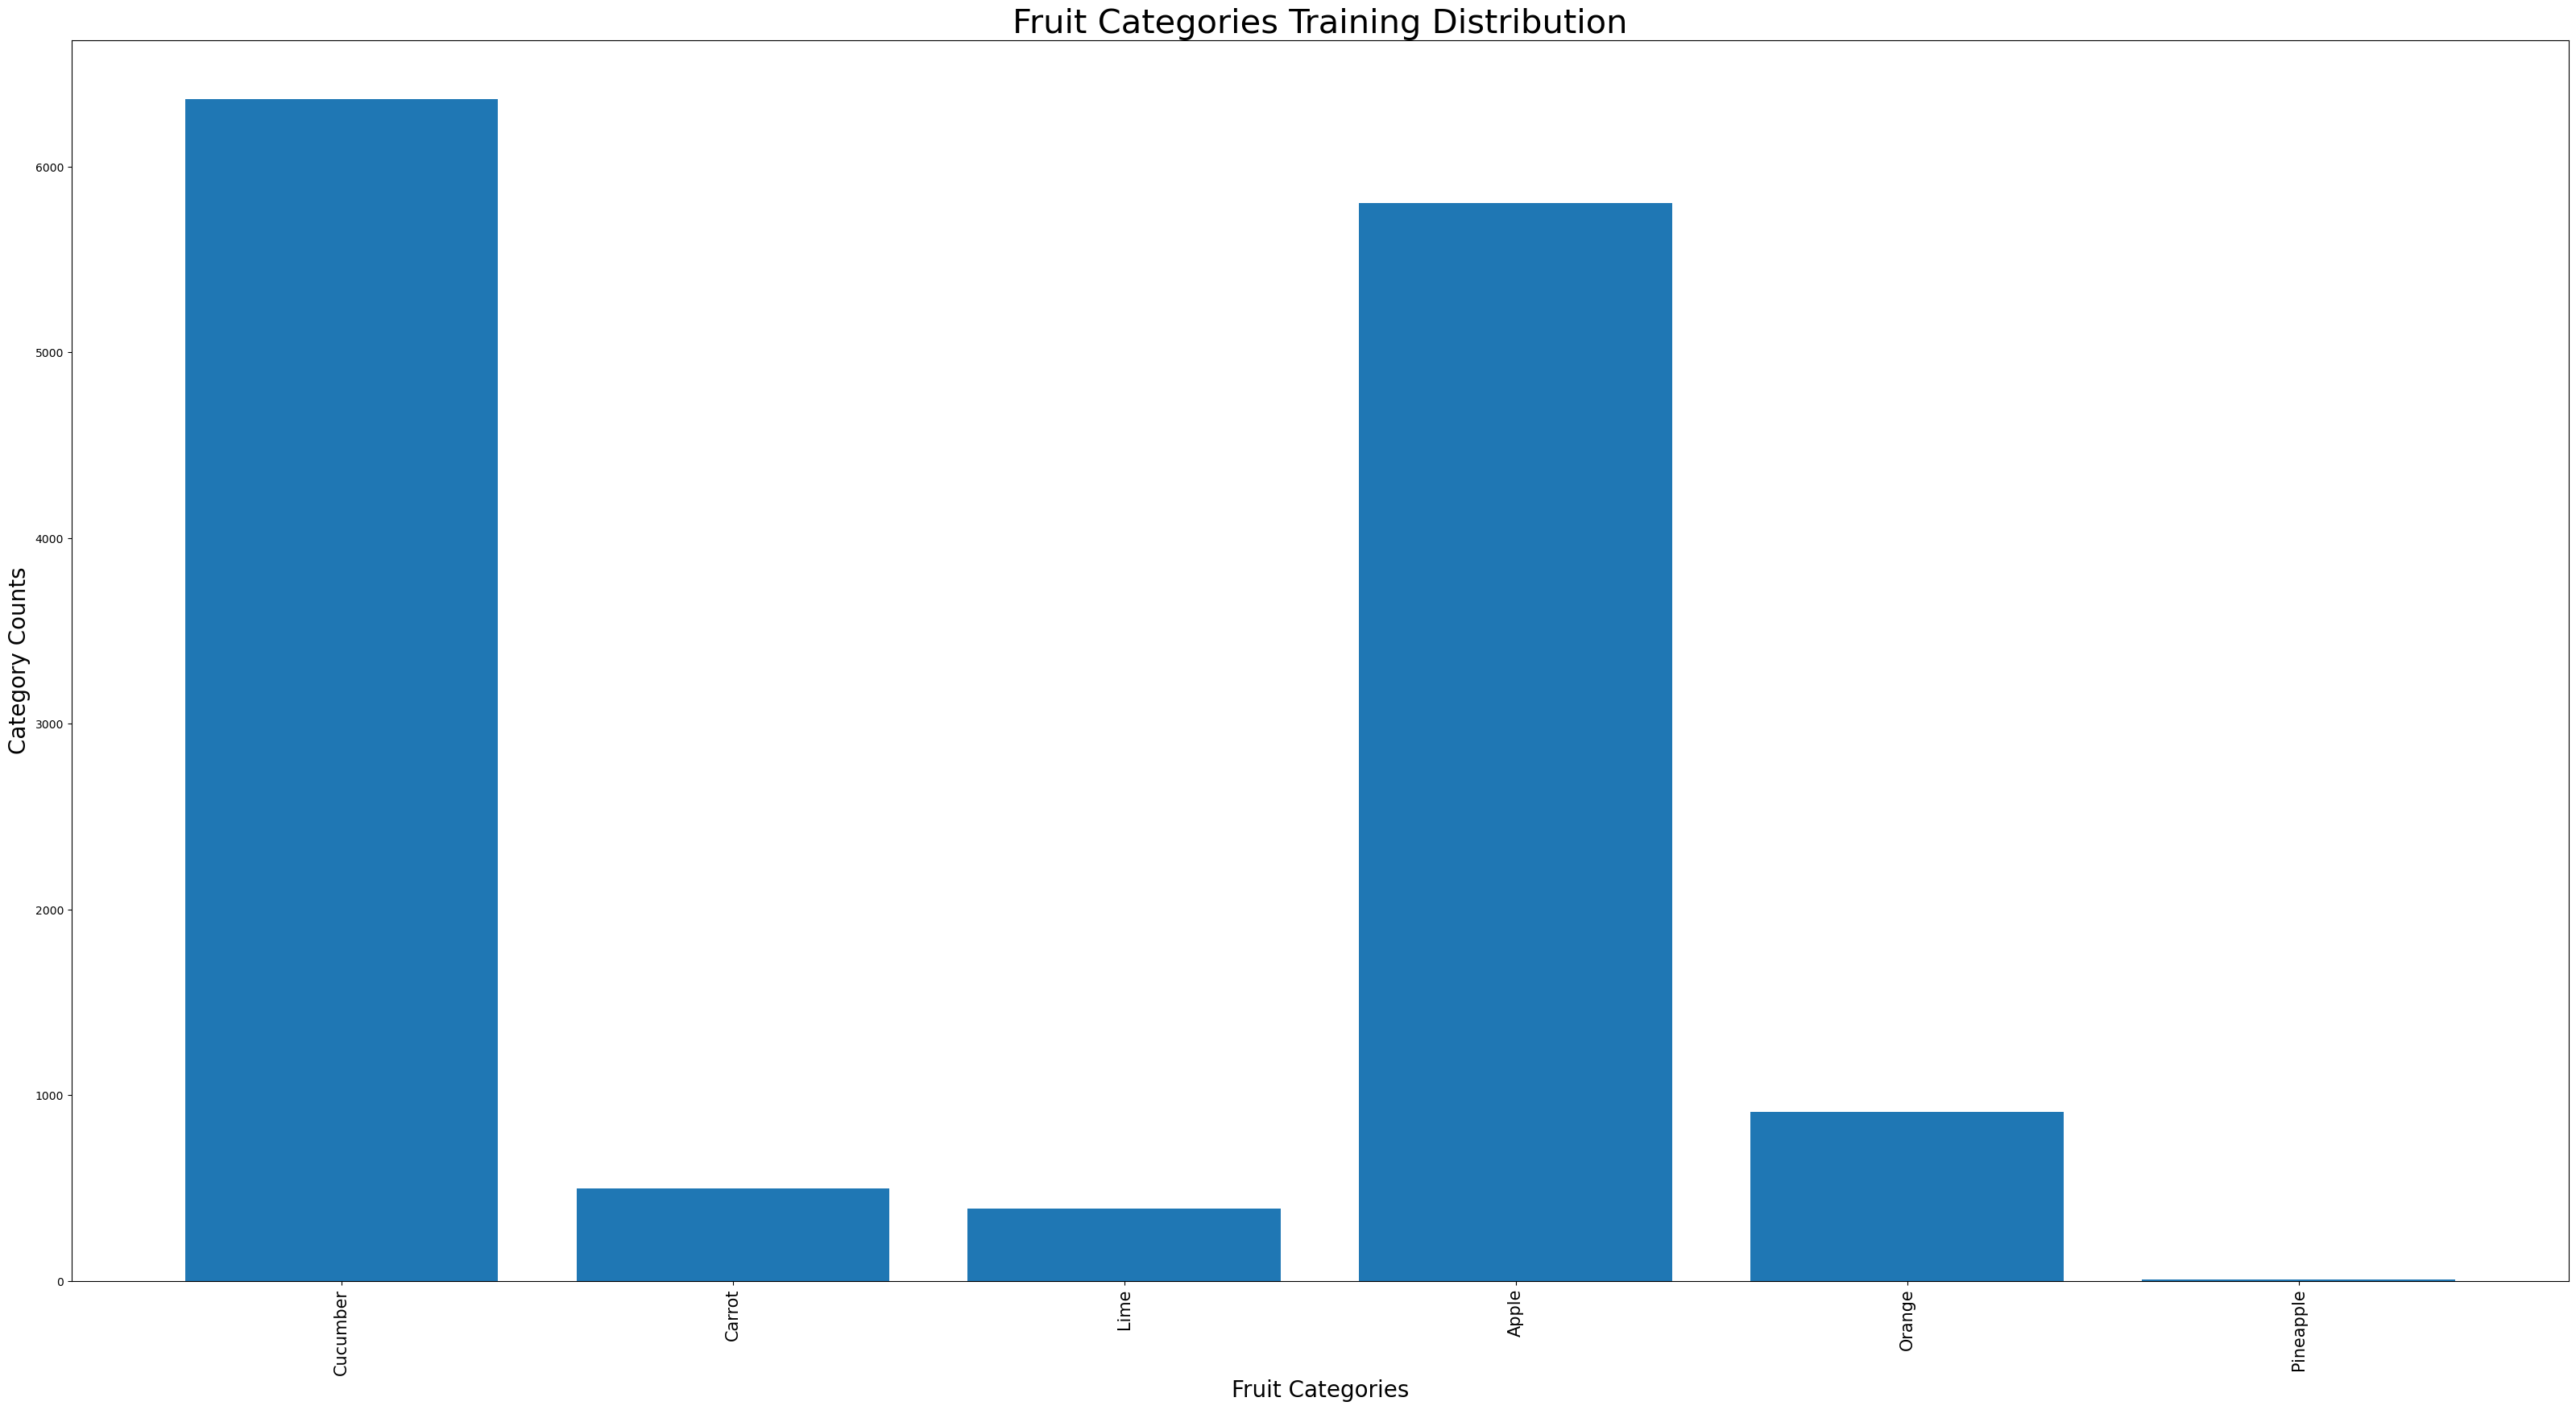

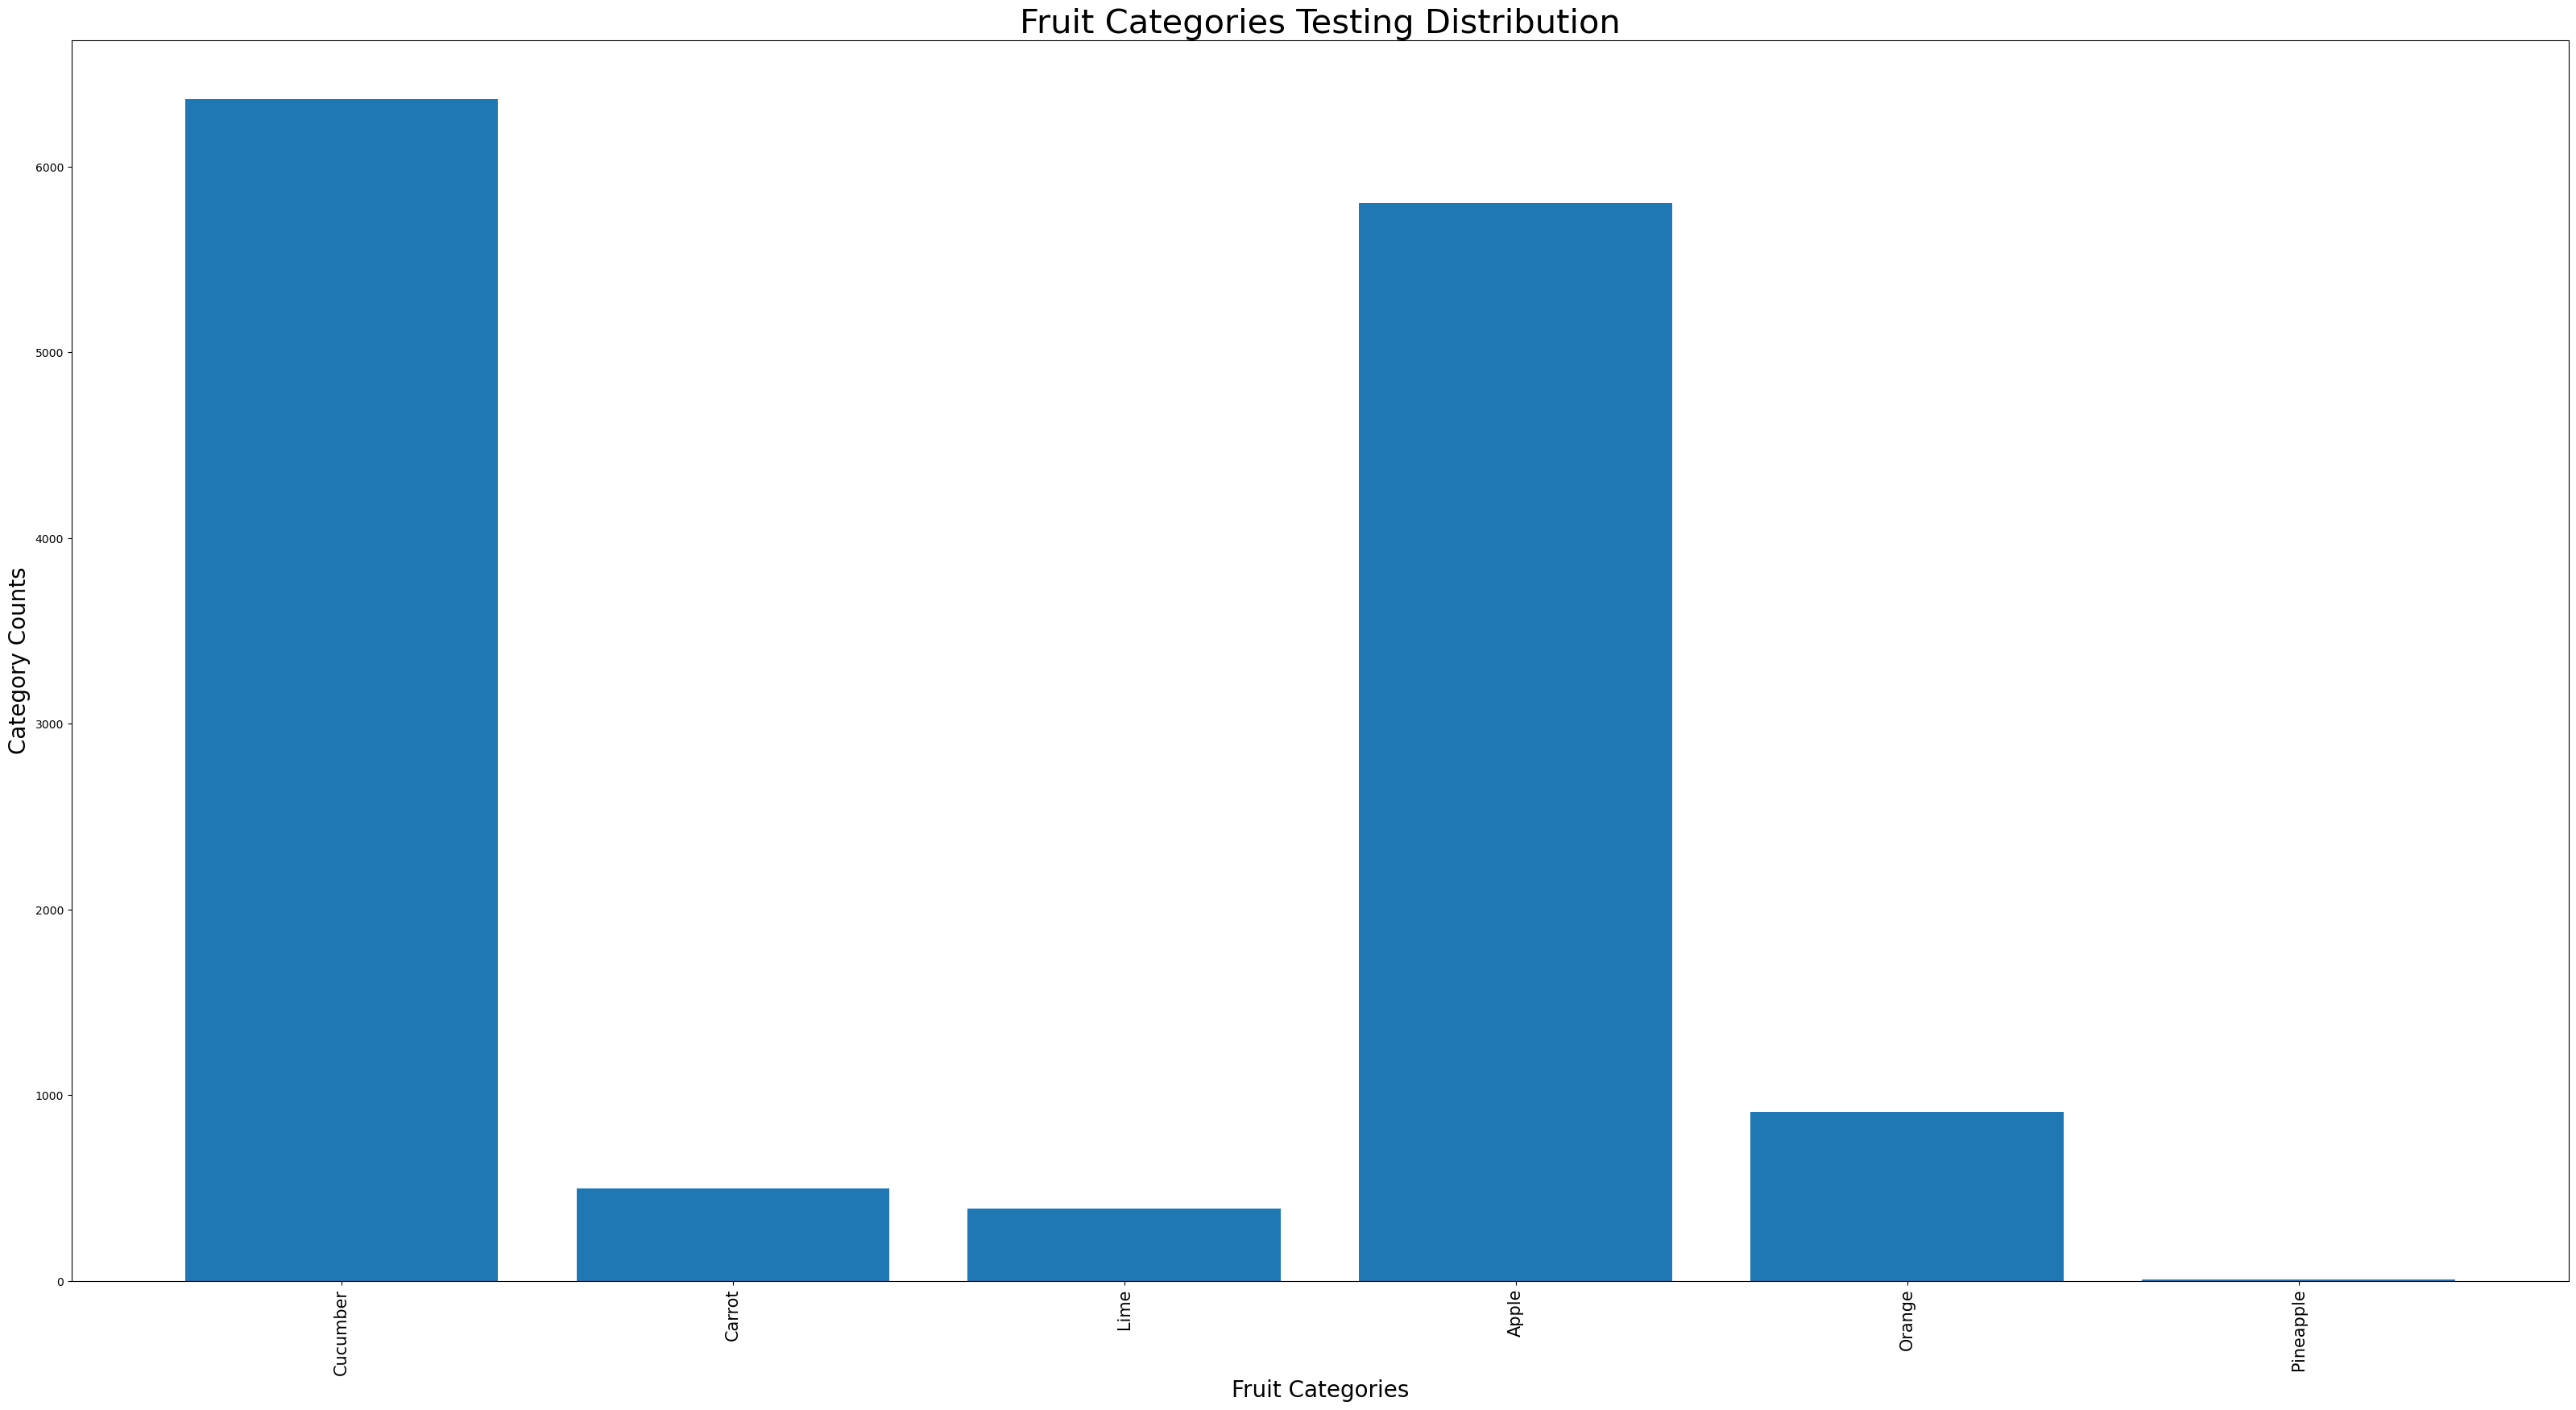

In [25]:
def plot_category_counts(path,xlabel,ylabel,title):
    categories = []
    counts = []
    for dir in os.listdir(path):
        categories.append(dir)
        counts.append(len(os.listdir(train_dir+"/"+ dir)))
    
    plt.rcParams["figure.figsize"] = (40,20)
    index = np.arange(len(categories))
    plt.bar(index, counts)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(index, categories, fontsize=15, rotation=90)
    plt.title(title, fontsize=30)
    plt.show()

plot_category_counts(train_dir+"/",'Fruit Categories','Category Counts','Fruit Categories Training Distribution')
plot_category_counts(test_dir+"/",'Fruit Categories','Category Counts','Fruit Categories Testing Distribution')

<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "4">4 - Learning Rate Scheduler & EarlyStopping </a></h2></b>
</div>

To have more control in the future problems, I choose creating a class instead of using ReduceLROnPlateau directly. And there is an EarlyStopping class with minimum requirements.

In [26]:
class LRScheduler():
    def __init__(self, optimizer, patience=5, min_lr=1e-7, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,mode='min',patience=self.patience,factor=self.factor,min_lr=self.min_lr,verbose=True)
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0,save_best=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_best=save_best
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            if self.save_best:
                self.save_best_model()
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.save_best:
                self.save_best_model()
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    def save_best_model(self):
        print(">>> Saving the current model with the best loss value...")
        print("-"*100)
        torch.save(model.state_dict(), 'best_loss_model_finetuned.pth')

<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "5">5 - CNN Model </a></h2></b>
</div>

In [27]:
class Fruits_CNN(nn.Module):
    def __init__(self):
        super(Fruits_CNN, self).__init__()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=5, stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 16*50*50

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 32*25*25

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=5, stride=5)
        # 64*5*5 = 1600 >> it is in_features value for the self.linear1

        self.flatten1 = nn.Flatten()

        self.linear1 = nn.Linear(in_features=1600, out_features=512)
        self.dropout1 = nn.Dropout(p=0.25)
        self.linear2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.maxpool3(out)

        out = self.flatten1(out)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.linear2(out)

        return out

<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "6">6 - Instantiate Classes </a></h2></b>
</div>

In [28]:
model = Fruits_CNN()
# model.load_state_dict(torch.load('best_loss_model.pth'))

if CUDA:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = LRScheduler(optimizer= optimizer,patience=5,min_lr=1e-7, factor=0.5)
early_stopping = EarlyStopping(patience=15, min_delta=0, save_best=True)

print(summary(model, (num_channels, image_height,image_width),batch_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [512, 16, 100, 100]           1,216
       BatchNorm2d-2        [512, 16, 100, 100]              32
              ReLU-3        [512, 16, 100, 100]               0
         MaxPool2d-4          [512, 16, 50, 50]               0
            Conv2d-5          [512, 32, 50, 50]           8,224
       BatchNorm2d-6          [512, 32, 50, 50]              64
              ReLU-7          [512, 32, 50, 50]               0
         MaxPool2d-8          [512, 32, 25, 25]               0
            Conv2d-9          [512, 64, 25, 25]          18,496
      BatchNorm2d-10          [512, 64, 25, 25]             128
             ReLU-11          [512, 64, 25, 25]               0
        MaxPool2d-12            [512, 64, 5, 5]               0
          Flatten-13                [512, 1600]               0
           Linear-14                 [5

/home/alison/anaconda3/envs/Atharva/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "7">7 - Training </a></h2></b>
</div>

In [29]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

print('Start Training')
print('*'*100)

for epoch in range(num_epochs):
    start_time = datetime.now()

    # TRAINING
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(dataloader_train):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    train_loss.append(iter_loss / iterations)
    train_accuracy.append(100 * correct / len(train_dataset))

    # TESTING
    loss_testing = 0.0
    correct = 0
    iterations = 0

    model.eval()

    for i, (inputs, labels) in enumerate(dataloader_test):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss_testing += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

        iterations += 1

    test_loss.append(loss_testing / iterations)
    test_accuracy.append(100 * correct / len(test_dataset))

    print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
          .format(epoch + 1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

    end_time = datetime.now()
    epoch_time = (end_time - start_time).total_seconds()
    print("-"*100)
    print('Epoch Time : ', math.floor(epoch_time // 60), ':', math.floor(epoch_time % 60))
    print("-"*100)

    lr_scheduler(test_loss[-1])
    early_stopping(test_loss[-1])
    if early_stopping.early_stop:
        print('*** Early stopping ***')
        break

print("*** Training Completed ***")

/home/alison/anaconda3/envs/Atharva/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Start Training
****************************************************************************************************
Epoch 1/100, Training Loss: 0.982, Training Accuracy: 66.903, Testing Loss: 0.632, Testing Acc: 76.890
----------------------------------------------------------------------------------------------------
Epoch Time :  0 : 51
----------------------------------------------------------------------------------------------------
>>> Saving the current model with the best loss value...
----------------------------------------------------------------------------------------------------
Epoch 2/100, Training Loss: 0.492, Training Accuracy: 82.578, Testing Loss: 0.402, Testing Acc: 86.047
----------------------------------------------------------------------------------------------------
Epoch Time :  0 : 53
----------------------------------------------------------------------------------------------------
>>> Saving the current model with the best loss value...
-----------------

<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "8">8 - Analysing Results </a></h2></b>
</div>

I will not use confusion matrix, since:
* To show 131 classes in confusion matrix is hard
* Model is successfull enough



/home/alison/anaconda3/envs/Atharva/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


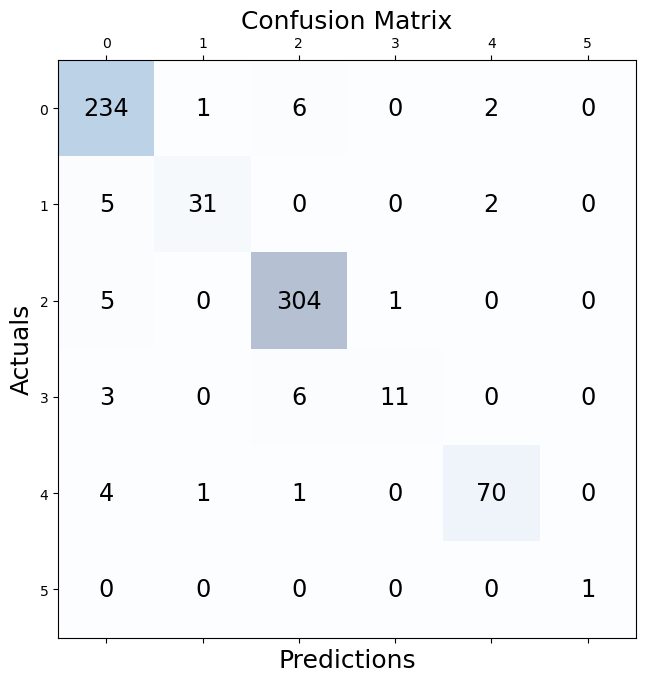

In [40]:
from sklearn.metrics import confusion_matrix

model.eval()

y_test = []
y_pred = []

for i, (inputs, labels) in enumerate(dataloader_test):
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    y_test.append(labels.cpu().detach().numpy())
    y_pred.append(predicted.cpu().numpy())

y_test = y_test[0]
y_pred = y_pred[0]

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
# -------- testing on real-world data ----------
label_dict = {0: 'Apple',
              1: 'Carrot',
              2: 'Cucumber',
              3: 'Lime',
              4: 'Orange',
              5: 'Pineapple'}

model.eval()

images = None # import image to process

if CUDA:
    images = images.cuda()

outputs = model(inputs)
_, predicted = torch.max(outputs, 1)

print("Predicted Number: ", predicted)
print("Predicted Class: ", label_dict[predicted])

train_accuracy and test accuracy is like:

> [tensor(76.8569, device='cuda:0'),tensor(99.1757, device='cuda:0'),tensor(99.7666, device='cuda:0'), ...., tensor(100., device='cuda:0')] 

I don't want to change the training code. We need to convert them to plain lists as below: 

In [30]:
def list_of_tensors_to_list(tensor_list):
    accuracy = []
    for tensor_item in tensor_list:
        accuracy.append(tensor_item.item())
    return accuracy

train_accuracy = list_of_tensors_to_list(train_accuracy)
test_accuracy = list_of_tensors_to_list(test_accuracy)

Below are the loss and accuracy plots. I have changed ylim values for smoother lines. Otherwise pyplot uses smaller interval for ylim which makes the plot more spiky.

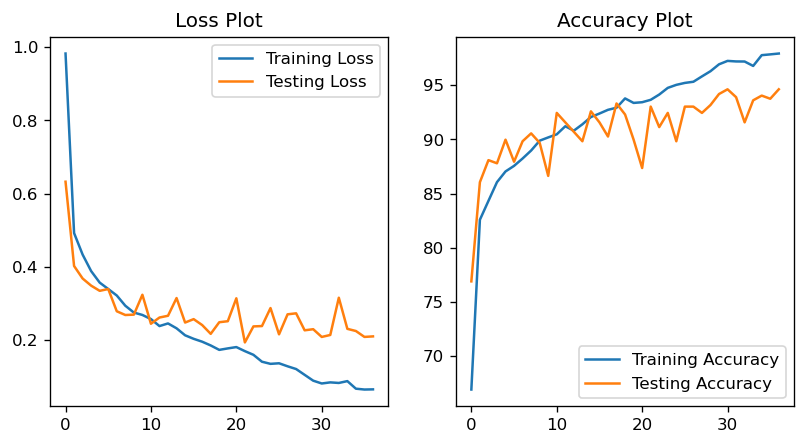

In [31]:
fig, ax = plt.subplots(1,2,figsize=(8,4), dpi=120)

# Loss
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(test_loss, label='Testing Loss')
# ax[0].axis(ymin=-0.10, ymax=10)
ax[0].set_title('Loss Plot')
ax[0].legend()

# Accuracy
ax[1].plot(train_accuracy, label='Training Accuracy')
ax[1].plot(test_accuracy, label='Testing Accuracy')
# ax[1].axis(ymin=0, ymax=101)
ax[1].set_title('Accuracy Plot')
ax[1].legend()
plt.show()

<div style="background-color:#B0C4DE;color:Navy;width:100%;display:inline-block;">
    <b><h2>&nbsp <a id = "9">9 - Summary </a></h2></b>
</div>

The model has approximately 99.30% test accuracy for a simple model. This is the power of CNN, not mine. 
My next notebook will be about ResNet.